# Slow-waves detection

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

## Data loading and preprocessing

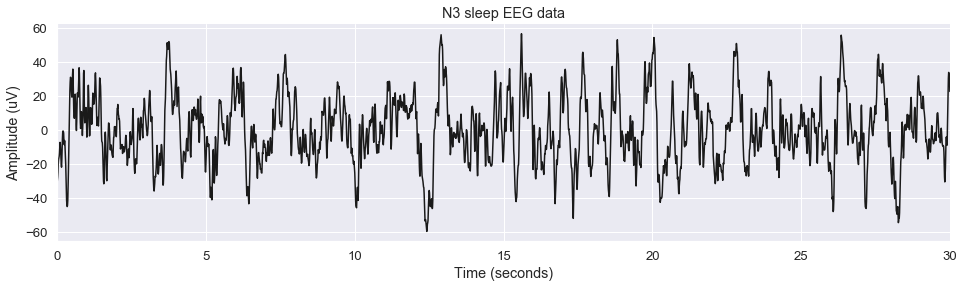

In [2]:
# Load data
data = np.loadtxt('data_N3_no-spindles_30sec_100Hz.txt')

# Define sampling frequency and time vector
sf = 100.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

Setting up band-pass filter from 0.3 - 3.5 Hz
Filter length of 1651 samples (16.510 sec) selected
Using filter length: 1651
Smart-padding with:  1650 samples on each edge
FFT block length:   8192


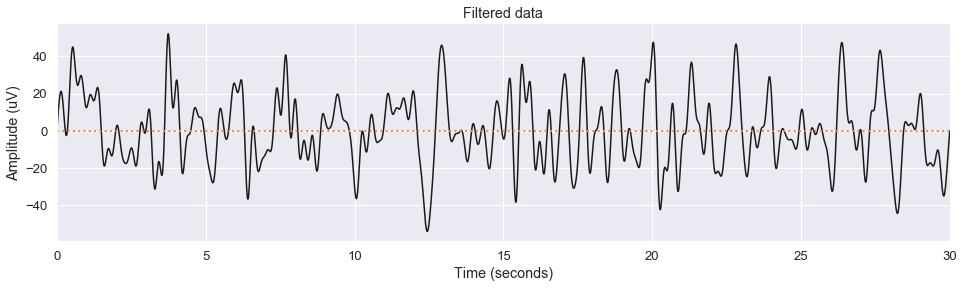

In [3]:
# Slow-waves bandpass filter
freq_sw = (0.3, 3.5)
data_filt = filter_data(data, sf, freq_sw[0], freq_sw[1], method='fir', verbose=1, 
                        l_trans_bandwidth=0.2, h_trans_bandwidth=0.2)

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.axhline(0, color='coral', ls=':', lw=2)
plt.title('Filtered data')
sns.despine()

## Detection

1. Negative peak < -40 uV

In [4]:
from scipy.signal import argrelmin

# Find all the values that are < -40 uV
idx_neg_below_40 = np.where(data_filt < -40)[0]

# Now find the local negative peaks in these supra-threshold clusters
idx_neg_peak = idx_neg_below_40[argrelmin(data_filt[idx_neg_below_40])[0]]
val_neg_peak = data_filt[idx_neg_peak]

print(idx_neg_peak, val_neg_peak)

[1244 2026 2823] [-54.12403075 -42.40833146 -44.46200758]


2. Now, for each of these negative peaks, we find the closest positive peak value in the 2 following seconds. Note that the peak-to-peak amplitude must be > 75 uV.

In [5]:
from scipy.signal import argrelmax, find_peaks

# Define empty vectors
ptp_criterion = np.zeros(idx_neg_peak.shape, dtype=bool)
idx_pos_peak = np.zeros(idx_neg_peak.shape, dtype=int)
val_pos_peak = np.zeros(idx_neg_peak.shape)

for i, (idx_pk, val_neg_pk) in enumerate(zip(idx_neg_peak, val_neg_peak)):
    print(i, idx_pk, val_neg_pk)
    idx = np.arange(idx_pk, idx_pk + 2 * sf, dtype=int)
    # Make sure that our index vector stay in bounds of data
    if idx[-1] > data_filt.size:
        idx = idx[idx < data_filt.size]
    # Find closest maxima that satisfies ptp amplitude
    height = 75 + val_neg_pk
    idx_maxima = find_peaks(data_filt[idx], height=height)[0]
    # Append good slow waves
    if len(idx_maxima) >= 1:
        idx_pos_peak[i] = idx[idx_maxima[0]]
        ptp_criterion[i] = True
    
# Keep only good SW
idx_neg_peak = idx_neg_peak[ptp_criterion]
idx_pos_peak = idx_pos_peak[ptp_criterion]
print(idx_neg_peak, idx_pos_peak)

0 1244 -54.12403074958169
1 2026 -42.40833146082592
2 2823 -44.462007578254344
[1244 2026] [1292 2131]


3. Now check the deflection length

In [6]:
def crossings_nonzero_all(data):
    pos = data > 0
    npos = ~pos
    return ((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0]

zero_crossings = crossings_nonzero_all(data_filt)
zero_crossings

array([  28,   34,  148,  197,  207,  278,  292,  298,  316,  361,  412,
        449,  494,  539,  561,  576,  629,  656,  662,  726,  782,  790,
        808,  885,  982, 1048, 1066, 1096, 1209, 1271, 1318, 1355, 1359,
       1392, 1404, 1425, 1435, 1465, 1494, 1506, 1530, 1551, 1598, 1646,
       1660, 1687, 1719, 1755, 1781, 1809, 1837, 1861, 1896, 1919, 1925,
       1966, 2015, 2060, 2074, 2113, 2161, 2181, 2198, 2252, 2301, 2333,
       2341, 2364, 2405, 2433, 2442, 2492, 2511, 2532, 2542, 2554, 2570,
       2618, 2675, 2697, 2700, 2729, 2794, 2844, 2911], dtype=int64)

In [7]:
neg_dur_thres = (sf * 0.125, sf * 1.5)
pos_dur_thres = 1 * sf

crit_neg_deflection = np.zeros(idx_neg_peak.shape, dtype=bool)
crit_pos_deflection = np.zeros(idx_pos_peak.shape, dtype=bool)
dur_neg_deflection = np.zeros(idx_neg_peak.shape)  # In seconds
dur_pos_deflection = np.zeros(idx_neg_peak.shape)  # In seconds

for i, (idx_neg_pk, idx_pos_pk) in enumerate(zip(idx_neg_peak, idx_pos_peak)):
    print(i, idx_neg_pk, idx_pos_pk)
    
    # Negative peak
    distance_zc = idx_neg_pk - zero_crossings
    previous_zc = np.max(distance_zc[distance_zc < 0])
    next_zc = np.min(distance_zc[distance_zc > 0])
    dur_neg = (-1 * previous_zc + next_zc)
    if neg_dur_thres[0] < dur_neg < neg_dur_thres[1]:
        dur_neg_deflection[i] = dur_neg / sf
        crit_neg_deflection[i] = True
    
    # Positive peak
    distance_zc = idx_pos_pk - zero_crossings
    previous_zc = np.max(distance_zc[distance_zc < 0])
    next_zc = np.min(distance_zc[distance_zc > 0])
    dur_pos = (-1 * previous_zc + next_zc)
    if dur_pos < pos_dur_thres:
        dur_pos_deflection[i] = dur_pos / sf
        crit_pos_deflection[i] = True
        
# Keep only good SW
def_criterion = np.logical_and(crit_neg_deflection, crit_pos_deflection)
idx_neg_peak = idx_neg_peak[def_criterion]
idx_pos_peak = idx_pos_peak[def_criterion]
dur_neg_deflection = dur_neg_deflection[def_criterion]
dur_pos_deflection = dur_pos_deflection[def_criterion]
print(dur_neg_deflection, dur_pos_deflection)

0 1244 1292
1 2026 2131
[0.62 0.45] [0.47 0.48]


## Create DataFrame

**Q: Should we take the filtered or unfiltered data?**

See https://www.spisop.org/documentation/#Slow_oscillations


![spisop](https://www.spisop.org/wp-content/uploads/2016/04/SO_full-01-750x500.png)

In [8]:
# First we take the unfiltered data
val_neg_peak = data[idx_neg_peak]
val_pos_peak = data[idx_pos_peak]

# And then compute other metrics
ptp = abs(val_neg_peak - val_pos_peak)
distance_peaks = times[idx_pos_peak] - times[idx_neg_peak]
slope = ptp / distance_peaks

In [9]:
pd.DataFrame({'IdxNegPeak': times[idx_neg_peak], 'IdxPosPeak': times[idx_pos_peak], 'DistancePeaks': distance_peaks, 
              'ValNegPeak': val_neg_peak, 'ValPosPeak': val_pos_peak, 'PTP': ptp, 'Slope': slope, 
              'DurNegPhase': dur_neg_deflection, 'DurPosPhase': dur_pos_deflection, 
              'TotalDur': dur_neg_deflection + dur_pos_deflection,
              'Frequency': 1 / (dur_neg_deflection + dur_pos_deflection),
              }).round(3)

,IdxNegPeak,IdxPosPeak,DistancePeaks,ValNegPeak,ValPosPeak,PTP,Slope,DurNegPhase,DurPosPhase,TotalDur,Frequency
0,12.44,12.92,0.48,-55.359,51.063,106.422,221.712,0.62,0.47,1.09,0.917
1,20.26,21.31,1.05,-42.534,29.356,71.891,68.467,0.45,0.48,0.93,1.075


## Final rejection